NECESSARY STEP: Import all required packages.

In [63]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import calendar

STEP 1: Acquiring the Dataset from Kaggle: https://www.kaggle.com/code/esparko/getting-started-tweet2map-dataset/input

In [64]:
# Read the file path from Kaggle and return a DataFrame of recorded road accidents in Metro Manila from 2018-2020
data = pd.read_csv("data_mmda_traffic_spatial.csv")

# Display the first few rows of the DataFrame
data.head()

,Date,Time,City,Location,Latitude,Longitude,High_Accuracy,Direction,Type,Lanes_Blocked,Involved,Tweet,Source
0,2018-08-20,7:55 AM,Pasig City,ORTIGAS EMERALD,14.586343,121.061481,1,EB,VEHICULAR ACCIDENT,1.0,TAXI AND MC,MMDA ALERT: Vehicular accident at Ortigas Emer...,https://twitter.com/mmda/status/10313302019705...
1,2018-08-20,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1.0,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313462477459...
2,2018-08-20,9:13 AM,Makati City,EDSA ROCKWELL,14.559818,121.040737,1,SB,VEHICULAR ACCIDENT,1.0,SUV AND L300,MMDA ALERT: Vehicular accident at EDSA Rockwel...,https://twitter.com/mmda/status/10313589669896...
3,2018-08-20,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1.0,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313590696535...
4,2018-08-20,10:27 AM,San Juan,ORTIGAS CLUB FILIPINO,14.601846,121.046754,1,EB,VEHICULAR ACCIDENT,1.0,2 CARS,MMDA ALERT: Vehicular accident at Ortigas Club...,https://twitter.com/mmda/status/10313711248424...


Step 2: Preprocessing the Dataset

In [65]:
# Drop rows with NaN, 0.0, irrelevant, and duplicate values
data.dropna(subset=["Date", "Time", "Longitude", "Latitude"], inplace=True)
data = data[(data['Latitude'] != 0.0) & (data['Longitude'] != 0.0) & (data['Time'] != 0.0) & (data['Date'] != 0.0)]
data.drop(["Source", "High_Accuracy", "Tweet", "Direction", "Type", "Lanes_Blocked", "Involved"], axis=1, inplace=True)
data.drop_duplicates(inplace=True)

# Convert Longitude and Latitude to float
data["Longitude"] = data["Longitude"].astype(float)
data["Latitude"] = data["Latitude"].astype(float)

# Extract the Hour, Minute, and AM/PM Information from the Time Column
time_pattern = r'(\d{1,2}):(\d{2})\s*(AM|PM)'
data[["Hour", "Minute", "AM/PM"]] = data["Time"].str.extract(time_pattern, expand=True)

# Fill-in missing values of the Hour and Minute columns with 0
data["Hour"].fillna(0, inplace=True)
data["Minute"].fillna(0, inplace=True)

# Convert the Hour and Minute Columns to integer
data["Hour"] = data["Hour"].astype(int)
data["Minute"] = data["Minute"].astype(int)

# 12-hour format to 24-hour format
data.loc[data["AM/PM"] == "PM", "Hour"] += 12

# Handles invalid hour values by using modulo division
data.loc[data["Hour"] > 23, "Hour"] = data["Hour"] % 24

# Handles invalid minute values by using modulo division
data.loc[data["Minute"] > 59, "Minute"] = data["Minute"] % 60

# New Time column with the format HH:MM
data["Time"] = data["Hour"].map("{:02d}".format) + ":" + data["Minute"].map("{:02d}".format)

# Combines the Date and Time to datetime format and maps to their corresponding ordinal representation
data["Datetime"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.head()

<ipython-input-65-e3a07dc5b7c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["Source", "High_Accuracy", "Tweet", "Direction", "Type", "Lanes_Blocked", "Involved"], axis=1, inplace=True)
<ipython-input-65-e3a07dc5b7c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)
<ipython-input-65-e3a07dc5b7c7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

,Date,Time,City,Location,Latitude,Longitude,Hour,Minute,AM/PM,Datetime
0,2018-08-20,07:55,Pasig City,ORTIGAS EMERALD,14.586343,121.061481,7,55,AM,2018-08-20 07:55:00
1,2018-08-20,08:42,Mandaluyong,EDSA GUADIX,14.589432,121.057243,8,42,AM,2018-08-20 08:42:00
2,2018-08-20,09:13,Makati City,EDSA ROCKWELL,14.559818,121.040737,9,13,AM,2018-08-20 09:13:00
4,2018-08-20,10:27,San Juan,ORTIGAS CLUB FILIPINO,14.601846,121.046754,10,27,AM,2018-08-20 10:27:00
5,2018-08-20,11:18,Makati City,C5 KALAYAAN,14.556079,121.062936,11,18,AM,2018-08-20 11:18:00


Step 3: Clustering using the K-means Algorithm

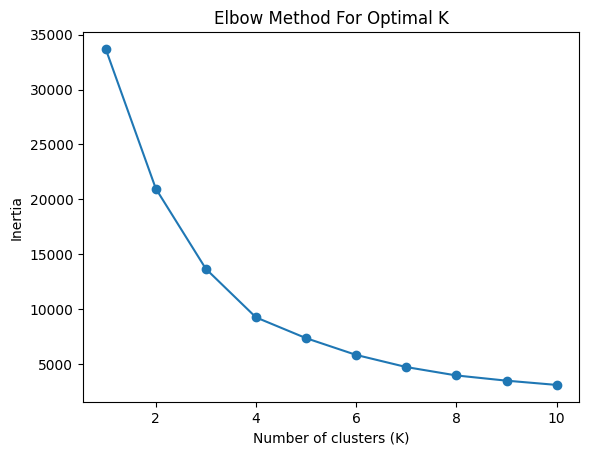

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Original Dataset
             Date   Time         City                      Location  \
0      2018-08-20  07:55   Pasig City               ORTIGAS EMERALD   
1      2018-08-20  08:42  Mandaluyong                   EDSA GUADIX   
2      2018-08-20  09:13  Makati City                 EDSA ROCKWELL   
4      2018-08-20  10:27     San Juan         ORTIGAS CLUB FILIPINO   
5      2018-08-20  11:18  Makati City                   C5 KALAYAAN   
...           ...    ...          ...                           ...   
17307  2020-12-27  00:59       Manila         QUIRINO GUAZON PETRON   
17308  2020-12-27  15:08  Makati City                 EDSA ESTRELLA   
17309  2020-12-27  15:23  Quezon City         EDSA P TUAZON FLYOVER   
17310  2020-12-27  19:46  Quezon City         ORTIGAS AVE EDSA POEA   
17311  2020-12-27  21:39       Manila  LEGARDA STA CATALINA COLLEGE   

        Latitude   Longitude  Hour  Minute AM/PM            Datetime  cluster  
0      14.586343  121.061481     7      55    AM 2

In [66]:
# Subset of columns that will be used for clustering
features = data[["Longitude", "Latitude"]]

# Standardize and scale the features first before clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Storage of inertia values for different values of K
inertia = []

# Determine the optimal number of clusters
for K in range(1, 11):
    # Perform K-means for each K and store its inertia value
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the K vs Inertia to visualize their relationship and use elbow method
plt.plot(range(1, 11), inertia, 'o-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

# This can be changed!
n_clusters=4

# Perform K-means with the optimal number of clusters
kmeans = KMeans(n_clusters, random_state=0)

# Assign and label each data record to a cluster
data["cluster"] = kmeans.fit_predict(scaled_features)

# Convert the "Datetime" column to datetime type
data["Datetime"] = pd.to_datetime(data["Datetime"])

# Group the data by cluster and month, and count the number of accidents
grouped_data = data.groupby(["cluster", data["Datetime"].dt.month]).size().reset_index(name='Accident_Count')

# Create a new DataFrame to store the accident counts for each cluster and month
cluster_datasets = []
for cluster_id in range(n_clusters): 
    # Finalize current cluster's data for the Month and Accident Count column
    cluster_data = grouped_data[grouped_data["cluster"] == cluster_id]
    cluster_data = cluster_data.rename(columns={'Datetime': 'Month'})
    cluster_data = cluster_data[['Month', 'Accident_Count']]
    cluster_data['Cluster'] = cluster_id
    cluster_datasets.append(cluster_data)

# Combine all cluster datasets into one
combined_data = pd.concat(cluster_datasets, ignore_index=True)

# Check if the sum of Accident Count is equal to the number of rows in the original dataset
accident_count_sum = combined_data.groupby('Cluster')['Accident_Count'].sum()
print("Original Dataset")
print(data)
print(f"Number of rows is: {len(data)}")
print("Dataset for Regression Analysis")
print(combined_data)
print(f"Total # of Accidents is: {sum(accident_count_sum)}")

Step 4: Modeling and Evaluating the Random Forest Regression models

In [89]:
# Perform regression for each cluster
regression_models = []

for cluster_id in range(n_clusters):
    cluster_data = combined_data[combined_data["Cluster"] == cluster_id]

    # Prepare features
    X = cluster_data[["Month"]]
    y = cluster_data["Accident_Count"]
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=2)
    
    # Create and train the Random Forest Regression model
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
        
    print(f"Cluster {cluster_id}:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2: {r2}")
    print()

    regression_models.append(model)

Cluster 0:
MSE: 268.88
MAE: 15.09
RMSE: 16.40
R^2: 0.9157984890002348

Cluster 1:
MSE: 3029.17
MAE: 46.79
RMSE: 55.04
R^2: 0.7914010226216299

Cluster 2:
MSE: 3028.85
MAE: 41.59
RMSE: 55.03
R^2: 0.824284694484329

Cluster 3:
MSE: 11537.75
MAE: 67.54
RMSE: 107.41
R^2: 0.8611601828794564



Step 5: Predicting using the Regression Models

In [90]:
# Predict the number of accidents given a month
input_month = 2
month_name = calendar.month_name[input_month]

# Initialize variables
highest_cluster = None
highest_accidents = 0

# Iterate through all clusters and their regression models
for cluster_id, model in enumerate(regression_models):
    # Predict the number of accidents for that month
    predicted_accidents = model.predict([[input_month]])
    print(f"Cluster {cluster_id} - Predicted Accidents for the month of {month_name}: {predicted_accidents[0]:.2f}")

    # Take note of the highest accident count
    if predicted_accidents[0] > highest_accidents:
        highest_cluster = cluster_id
        highest_accidents = predicted_accidents[0]

# Print the predicted highest accident count cluster
print(f"\nCluster {highest_cluster} has the highest number of accidents with {int(highest_accidents)} predicted accidents for the month of {month_name}.")
cluster_data = data[data['cluster'] == highest_cluster]

Cluster 0 - Predicted Accidents for the month of February: 194.97
Cluster 1 - Predicted Accidents for the month of February: 353.73
Cluster 2 - Predicted Accidents for the month of February: 269.01
Cluster 3 - Predicted Accidents for the month of February: 776.24

Cluster 3 has the highest number of accidents with 776 predicted accidents for the month of February.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Comparison with Original Model